# Final Project
Group 25 <br>
Swayam Patel | 22B1816 <br>
Dattaraj Salunkhe | 22B1296

## Importing Packages

In [34]:
import networkx as nx
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

## Classical Facility Location Problem

We first define a graph, then find the shortest paths between 2 points using the Djikstra's algorithm. In further parts, we have directly taken the shortest distance between any two points.<br>
We then declare the capacities and demands for each location(these are the parameters). Then, we declare two decision variables, $x_{ij}$, which denotes whether center $j$ will serve location $i$, and $y_{i}$, which denotes whether location $i$ is a facility.The objective function minimizes the total distance covered to serve all the locations.

In [35]:
# Define the graph using edge lists (larger, sparse graph)
edges = [
    ('L1', 'L2', 10), ('L2', 'L3', 15), ('L3', 'L4', 35),
    ('L1', 'L3', 20), ('L4', 'L5', 25), ('L5', 'L6', 30),
    ('L1', 'L5', 5), ('L4', 'L2', 35), ('L1', 'L6', 15)
]

# Create a graph and add edges with distances
G = nx.Graph()
G.add_weighted_edges_from(edges)

# Compute all pairs shortest path distances using Dijkstra's algorithm
shortest_paths = dict(nx.all_pairs_dijkstra_path_length(G))

# Locations (nodes in the graph)
locations = list(G.nodes)

In [36]:
# Define the demands and capacities for each location
demands = {'L1': 10, 'L2': 20, 'L3': 15, 'L4': 10, 'L5': 5, 'L6': 10}  # Demand at each location
capacities = {'L1': 30, 'L2': 40, 'L3': 30, 'L4': 30, 'L5': 20, 'L6': 20}  # Capacity of each center
k = 3  # Number of centers to open

In [37]:
# Create a Pyomo model
model = ConcreteModel()

# Sets
model.Locations = Set(initialize=locations)

# Parameters
model.Demand = Param(model.Locations, initialize=demands)
model.Capacity = Param(model.Locations, initialize=capacities)

In [38]:
# Convert shortest path distances into a format usable in Pyomo
def distance_init(model, i, j):
    # If there is no path between i and j, use a very large distance (infinity)
    if i in shortest_paths and j in shortest_paths[i]:
        return shortest_paths[i][j]
    else:
        return float('inf')  # If there's no path, treat it as unreachable

model.Distance = Param(model.Locations, model.Locations, initialize=distance_init)

In [39]:
# Decision variables
model.x = Var(model.Locations, model.Locations, domain=Binary)  # Assignment variable
model.y = Var(model.Locations, domain=Binary)  # Open center variable

In [40]:
# Objective: Minimize total transportation cost (distance)
def objective_rule(model):
    return sum(model.Distance[i, j] * model.x[i, j] for i in model.Locations for j in model.Locations)
model.objective = Objective(rule=objective_rule, sense=minimize)

In [41]:
# Constraint 1: Each location is assigned to exactly one center
def assignment_rule(model, i):
    return sum(model.x[i, j] for j in model.Locations) == 1
model.assignment_constraint = Constraint(model.Locations, rule=assignment_rule)

# Constraint 2: The total demand assigned to any center does not exceed its capacity
def capacity_rule(model, j):
    return sum(model.Demand[i] * model.x[i, j] for i in model.Locations) <= model.Capacity[j] * model.y[j]
model.capacity_constraint = Constraint(model.Locations, rule=capacity_rule)

# Constraint 3: Ensure that location i is assigned to location j only if j is a distribution center
def open_center_rule(model, i, j):
    return model.x[i, j] <= model.y[j]
model.open_center_constraint = Constraint(model.Locations, model.Locations, rule=open_center_rule)

# Constraint 4: Exactly k distribution centers must be opened
def number_of_centers_rule(model):
    return sum(model.y[j] for j in model.Locations) == k
model.num_centers_constraint = Constraint(rule=number_of_centers_rule)

In [42]:
# Solve the model
solver = SolverFactory('glpk')
solver.solve(model)

# Display the results
print("Selected Distribution Centers:")
for j in model.Locations:
    if model.y[j].value == 1:
        print(f"Location {j} is selected as a distribution center.")

print("\nAssignments:")
for i in model.Locations:
    for j in model.Locations:
        if model.x[i, j].value == 1:
            print(f"Location {i} is assigned to center {j}.")

Selected Distribution Centers:
Location L1 is selected as a distribution center.
Location L2 is selected as a distribution center.
Location L4 is selected as a distribution center.

Assignments:
Location L1 is assigned to center L1.
Location L2 is assigned to center L2.
Location L3 is assigned to center L2.
Location L4 is assigned to center L4.
Location L5 is assigned to center L1.
Location L6 is assigned to center L1.


In [43]:
#Checking if solver has reached optimum
results = solver.solve(model)
print("Solver Status:", results.solver.status)
print("Solver Termination Condition:", results.solver.termination_condition)

Solver Status: ok
Solver Termination Condition: optimal


In [44]:
#Another way to check if solver has reached optimum
optimal_cost = sum(
    model.Distance[i, j] * model.x[i, j].value
    for i in model.Locations
    for j in model.Locations
)
print("Optimal Cost from Solver:", model.objective())
print("Recalculated Cost:", optimal_cost)

Optimal Cost from Solver: 35.0
Recalculated Cost: 35.0


Since both the costs are same, the solver has reached optimum.

## Non-Deterministic CFLP

### Non-Deterministic Demand & Deterministic Capacity

Continuing from the CFLP, we now declare the demand to be a normal distribution, with a particular mean and standard deviation. We run a similar algorithm many times and each time we take a different value of the demands from the distribution. Each iteration yields the appropriate number of optimum centers, and we count the number of times each center has been selected as optimum. It is also possible that since the demand is a distribution, the problem might be infeasible. In that case, that iteration is counted as infeasible, and no increment happens in any of the centers. Finally, we plot a histogram, and then choose the number of centers required as the centers which have been chosen the most in the iterations.

In [45]:
# Define locations and parameters
locations = ['L1', 'L2', 'L3', 'L4']
distances = {
    ('L1', 'L1'): 0, ('L1', 'L2'): 10, ('L1', 'L3'): 20, ('L1', 'L4'): 30,
    ('L2', 'L1'): 10, ('L2', 'L2'): 0, ('L2', 'L3'): 15, ('L2', 'L4'): 25,
    ('L3', 'L1'): 20, ('L3', 'L2'): 15, ('L3', 'L3'): 0, ('L3', 'L4'): 35,
    ('L4', 'L1'): 30, ('L4', 'L2'): 25, ('L4', 'L3'): 35, ('L4', 'L4'): 0
}
capacities = {'L1': 30, 'L2': 30, 'L3': 30, 'L4': 30}
k = 2
mean_demand = 14
std_dev_demand = 2

# Simulation parameters
n_simulations = 2000  # Number of Monte Carlo simulations
selected_centers_count = Counter()
infeasible_count = 0

In [46]:
# Monte Carlo simulation
for sim in range(n_simulations):
    # Generate random demands
    demands = {loc: max(0, int(np.random.normal(mean_demand, std_dev_demand))) for loc in locations}
    total_demand = sum(demands.values())
    total_capacity = k * max(capacities.values())

    if total_demand > total_capacity:
        infeasible_count += 1
        continue  # Skip this iteration if infeasible

    # Create a Pyomo model
    model = ConcreteModel()
    model.Locations = Set(initialize=locations)
    model.Demand = Param(model.Locations, initialize=demands)
    model.Capacity = Param(model.Locations, initialize=capacities)
    model.Distance = Param(model.Locations, model.Locations, initialize=distances)
    model.x = Var(model.Locations, model.Locations, domain=Binary)
    model.y = Var(model.Locations, domain=Binary)

    # Objective
    def objective_rule(model):
        return sum(model.Distance[i, j] * model.x[i, j] for i in model.Locations for j in model.Locations)
    model.objective = Objective(rule=objective_rule, sense=minimize)

    # Constraints
    def assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.Locations) == 1
    model.assignment_constraint = Constraint(model.Locations, rule=assignment_rule)

    def capacity_rule(model, j):
        return sum(model.Demand[i] * model.x[i, j] for i in model.Locations) <= model.Capacity[j] * model.y[j]
    model.capacity_constraint = Constraint(model.Locations, rule=capacity_rule)

    def open_center_rule(model, i, j):
        return model.x[i, j] <= model.y[j]
    model.open_center_constraint = Constraint(model.Locations, model.Locations, rule=open_center_rule)

    def number_of_centers_rule(model):
        return sum(model.y[j] for j in model.Locations) == k
    model.num_centers_constraint = Constraint(rule=number_of_centers_rule)

    # Solve the model
    solver = SolverFactory('glpk')
    result = solver.solve(model)

    if (result.solver.status == 'ok') and (result.solver.termination_condition == 'optimal'):
        # Count the selected centers
        for j in model.Locations:
            if model.y[j].value == 1:
                selected_centers_count[j] += 1
    else:
        infeasible_count += 1

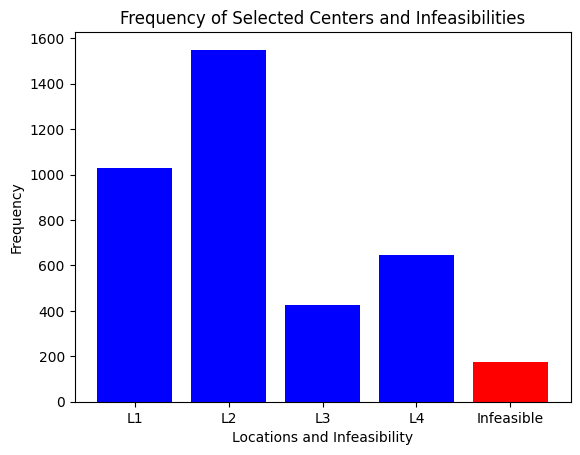

In [47]:
# Plot the results
locations_with_infeasible = locations + ["Infeasible"]
frequencies = [selected_centers_count[loc] for loc in locations] + [infeasible_count]

plt.bar(locations_with_infeasible, frequencies, color=['blue', 'blue', 'blue', 'blue', 'red'])
plt.title('Frequency of Selected Centers and Infeasibilities')
plt.xlabel('Locations and Infeasibility')
plt.ylabel('Frequency')
plt.show()

### Non-Deterministic Demand & Capacity

In this case, we treat capacity also as a normal distribution. We iterate in the same manner as explained in the previous part. Note that we have considered the standard deviation of the capacity significantly smaller than the standard deviation of the demand, as to be expected in real scenarios.

In [48]:
# Define locations and distances
locations = ['L1', 'L2', 'L3', 'L4']
distances = {
    ('L1', 'L1'): 0, ('L1', 'L2'): 10, ('L1', 'L3'): 20, ('L1', 'L4'): 30,
    ('L2', 'L1'): 10, ('L2', 'L2'): 0, ('L2', 'L3'): 15, ('L2', 'L4'): 25,
    ('L3', 'L1'): 20, ('L3', 'L2'): 15, ('L3', 'L3'): 0, ('L3', 'L4'): 35,
    ('L4', 'L1'): 30, ('L4', 'L2'): 25, ('L4', 'L3'): 35, ('L4', 'L4'): 0
}
k = 3
mean_demand = 10
std_dev_demand = 4
base_capacity = 30  # Base capacity
capacity_volatility = 0.1  # ±10% variation

# Simulation parameters
n_simulations = 2000  # Number of Monte Carlo simulations
selected_centers_count = Counter()
infeasible_count = 0

In [49]:
# Monte Carlo simulation
for sim in range(n_simulations):
    # Generate random demands and capacities
    demands = {loc: max(0, int(np.random.normal(mean_demand, std_dev_demand))) for loc in locations}
    capacities = {loc: int(base_capacity * (1 + np.random.uniform(-capacity_volatility, capacity_volatility))) for loc in locations}

    total_demand = sum(demands.values())
    total_capacity = k * max(capacities.values())

    if total_demand > total_capacity:
        infeasible_count += 1
        continue  # Skip this iteration if infeasible

    # Create a Pyomo model
    model = ConcreteModel()
    model.Locations = Set(initialize=locations)
    model.Demand = Param(model.Locations, initialize=demands)
    model.Capacity = Param(model.Locations, initialize=capacities)
    model.Distance = Param(model.Locations, model.Locations, initialize=distances)
    model.x = Var(model.Locations, model.Locations, domain=Binary)
    model.y = Var(model.Locations, domain=Binary)

    # Objective
    def objective_rule(model):
        return sum(model.Distance[i, j] * model.x[i, j] for i in model.Locations for j in model.Locations)
    model.objective = Objective(rule=objective_rule, sense=minimize)

    # Constraints
    def assignment_rule(model, i):
        return sum(model.x[i, j] for j in model.Locations) == 1
    model.assignment_constraint = Constraint(model.Locations, rule=assignment_rule)

    def capacity_rule(model, j):
        return sum(model.Demand[i] * model.x[i, j] for i in model.Locations) <= model.Capacity[j] * model.y[j]
    model.capacity_constraint = Constraint(model.Locations, rule=capacity_rule)

    def open_center_rule(model, i, j):
        return model.x[i, j] <= model.y[j]
    model.open_center_constraint = Constraint(model.Locations, model.Locations, rule=open_center_rule)

    def number_of_centers_rule(model):
        return sum(model.y[j] for j in model.Locations) == k
    model.num_centers_constraint = Constraint(rule=number_of_centers_rule)

    # Solve the model
    solver = SolverFactory('glpk')
    result = solver.solve(model)

    if (result.solver.status == 'ok') and (result.solver.termination_condition == 'optimal'):
        # Count the selected centers
        for j in model.Locations:
            if model.y[j].value == 1:
                selected_centers_count[j] += 1
    else:
        infeasible_count += 1

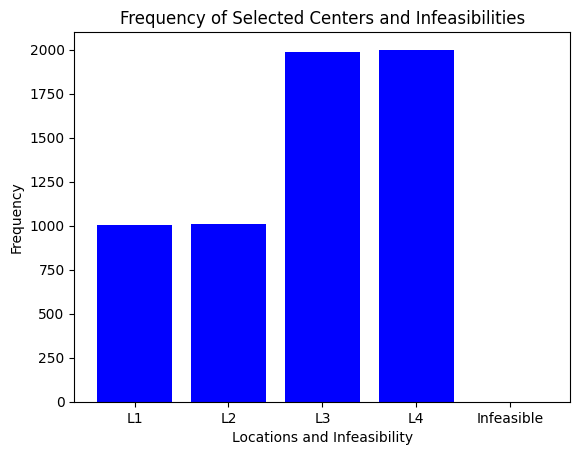

In [50]:
# Plot the results
locations_with_infeasible = locations + ["Infeasible"]
frequencies = [selected_centers_count[loc] for loc in locations] + [infeasible_count]

plt.bar(locations_with_infeasible, frequencies, color=['blue', 'blue', 'blue', 'blue', 'red'])
plt.title('Frequency of Selected Centers and Infeasibilities')
plt.xlabel('Locations and Infeasibility')
plt.ylabel('Frequency')
plt.show()

## Competitive Facility Location Problem

In [51]:
# Sample data
customers = [1, 2, 3, 4, 5]  # Customer locations (IDs)
facilities = [1, 2, 3, 4, 5]  # Candidate facility locations (IDs)

# Distances between customers and facilities (rows: customers, cols: facilities)
distances = {
    (1, 1): 2, (1, 2): 5, (1, 3): 8, (1, 4): 6, (1, 5): 3,
    (2, 1): 7, (2, 2): 3, (2, 3): 4, (2, 4): 5, (2, 5): 9,
    (3, 1): 6, (3, 2): 4, (3, 3): 3, (3, 4): 8, (3, 5): 7,
    (4, 1): 5, (4, 2): 7, (4, 3): 2, (4, 4): 4, (4, 5): 6,
    (5, 1): 8, (5, 2): 6, (5, 3): 5, (5, 4): 3, (5, 5): 2,
}

# Parameters
num_facilities = {1: 2, 2: 1}  # Facilities each competitor can open
max_distance = 6              # Maximum allowable distance for coverage

In [52]:
# Create the Pyomo model
model = ConcreteModel()

# Sets
model.customers = Set(initialize=customers)
model.facilities = Set(initialize=facilities)
model.competitors = Set(initialize=[1, 2])  # Competitor 1 and 2

In [53]:
# Decision variables
model.x = Var(model.competitors, model.facilities, within=Binary)  # 1 if a competitor opens a facility
model.y = Var(model.competitors, model.customers, model.facilities, within=Binary)  # Assignment of customers

In [54]:
# Objective: Minimize the total cost for both competitors
model.obj = Objective(
    expr=sum(model.y[k, j, i] * distances[j, i] for k in model.competitors for j in model.customers for i in model.facilities),
    sense=minimize
)

In [55]:
# Constraints: Each customer must be served by one competitor
model.customer_served = ConstraintList()
for j in model.customers:
    model.customer_served.add(sum(model.y[k, j, i] for k in model.competitors for i in model.facilities) == 1)

# Constraints: Customers can only be assigned to facilities within the maximum allowable distance
model.max_distance = ConstraintList()
for k in model.competitors:
    for j in model.customers:
        for i in model.facilities:
            if distances[j, i] > max_distance:
                model.max_distance.add(model.y[k, j, i] == 0)

# Constraints: Customers can only be assigned to open facilities
model.open_facilities = ConstraintList()
for k in model.competitors:
    for j in model.customers:
        for i in model.facilities:
            model.open_facilities.add(model.y[k, j, i] <= model.x[k, i])

# Constraints: Each competitor can open a limited number of facilities
model.facility_limit = ConstraintList()
for k in model.competitors:
    model.facility_limit.add(sum(model.x[k, i] for i in model.facilities) == num_facilities[k])

In [56]:
# Solve the model
solver = SolverFactory('glpk')  # Ensure GLPK is installed or use another solver
result = solver.solve(model)

# Display the results
print("Facility Locations Opened by Competitors:")
for k in model.competitors:
    print(f"Competitor {k}:")
    for i in model.facilities:
        if model.x[k, i].value == 1:
            print(f"  Facility at location {i}")

print("\nCustomer Assignments:")
for j in model.customers:
    for k in model.competitors:
        for i in model.facilities:
            if model.y[k, j, i].value == 1:
                print(f"Customer {j} is served by Competitor {k} at Facility {i}")

print(f"\nTotal Cost: {model.obj.expr()}")

Facility Locations Opened by Competitors:
Competitor 1:
  Facility at location 2
  Facility at location 3
Competitor 2:
  Facility at location 5

Customer Assignments:
Customer 1 is served by Competitor 2 at Facility 5
Customer 2 is served by Competitor 1 at Facility 2
Customer 3 is served by Competitor 1 at Facility 3
Customer 4 is served by Competitor 1 at Facility 3
Customer 5 is served by Competitor 2 at Facility 5

Total Cost: 13.0


In [57]:
#Checking if solver has reached optimum
results = solver.solve(model)
print("Solver Status:", results.solver.status)
print("Solver Termination Condition:", results.solver.termination_condition)

Solver Status: ok
Solver Termination Condition: optimal


In [59]:
#Checking if solver has reached optimum
results = solver.solve(model)
print("Solver Status:", results.solver.status)
print("Solver Termination Condition:", results.solver.termination_condition)

Solver Status: ok
Solver Termination Condition: optimal


### Another Approach

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Problem Parameters
n_customers = 10  # Number of customer points
n_facilities = 10  # Number of candidate facility locations
m_competitors = 3  # Number of competitors
alpha = {1: 2, 2: 1, 3:2}  # Number of facilities each competitor can open
lambda_threshold = 2  # Maximum distance for coverage
min_unique_locations = 3  # Minimum unique facility locations across competitors
customer_demand = {j: 1 for j in range(1, n_customers + 1)}  # Demand at each customer point

# Distance matrix (random values here; replace with actual distances)
import random
random.seed(22)
distances = {(i, j): random.randint(1, 5) for i in range(1, n_facilities + 1) for j in range(1, n_customers + 1)}

# Set of candidate locations and customer points
I = range(1, n_facilities + 1)
J = range(1, n_customers + 1)

# Pyomo Model
model = ConcreteModel()

# Sets
model.I = Set(initialize=I)  # Facility locations
model.J = Set(initialize=J)  # Customer points
model.K = Set(initialize=range(1, m_competitors + 1))  # Competitors


In [2]:
# Parameters
model.distances = Param(model.I, model.J, initialize=distances)
model.customer_demand = Param(model.J, initialize=customer_demand)
model.lambda_threshold = lambda_threshold
model.alpha = Param(model.K, initialize=alpha)

# Variables
model.x = Var(model.K, model.I, domain=Binary)  # Whether competitor k places a facility at i
model.z = Var(model.K, model.I, model.J, domain=Binary)  # Whether customer j is covered by competitor k at facility i
model.pi = Var(model.K, domain=NonNegativeReals)  # Total demand covered by each competitor
model.y = Var(model.I, domain=Binary)  # Whether any facility is opened at location i

# Objective: Maximize total demand coverage for both competitors
model.objective = Objective(expr=sum(model.pi[k] for k in model.K), sense=maximize)

In [3]:
# Constraints
def coverage_constraint(model, k, j):
    """Ensure customer demand is covered by at most one facility per competitor."""
    return sum(model.z[k, i, j] for i in model.I if model.distances[i, j] <= model.lambda_threshold) <= 1

model.coverage_constraint = Constraint(model.K, model.J, rule=coverage_constraint)

def demand_coverage_constraint(model, k):
    """Calculate total demand covered by each competitor."""
    return model.pi[k] == sum(
        model.customer_demand[j] *
        sum(model.z[k, i, j] for i in model.I if model.distances[i, j] <= model.lambda_threshold)
        for j in model.J
    )

model.demand_coverage_constraint = Constraint(model.K, rule=demand_coverage_constraint)

def facility_limit_constraint(model, k):
    """Limit the number of facilities opened by each competitor."""
    return sum(model.x[k, i] for i in model.I) == model.alpha[k]

model.facility_limit_constraint = Constraint(model.K, rule=facility_limit_constraint)

def facility_activation_constraint(model, k, i, j):
    """Customer can be covered only if a facility exists at the location."""
    return model.z[k, i, j] <= model.x[k, i]

model.facility_activation_constraint = Constraint(model.K, model.I, model.J, rule=facility_activation_constraint)

# Constraints for Unique Locations
def link_y_to_x_constraint(model, i):
    """Link y[i] to competitors' facility decisions."""
    return model.y[i] >= sum(model.x[k, i] for k in model.K) / m_competitors

model.link_y_to_x_constraint = Constraint(model.I, rule=link_y_to_x_constraint)

def min_unique_locations_constraint(model):
    """Ensure a minimum number of unique facility locations."""
    return sum(model.y[i] for i in model.I) >= min_unique_locations

model.min_unique_locations_constraint = Constraint(rule=min_unique_locations_constraint)

# Exclusivity Constraint
def exclusivity_constraint(model, i):
    """Ensure no more than one competitor opens a facility at the same location."""
    return sum(model.x[k, i] for k in model.K) <= 1

model.exclusivity_constraint = Constraint(model.I, rule=exclusivity_constraint)


In [4]:
# Solver and Results
solver = SolverFactory('glpk')  # Use an appropriate solver
results = solver.solve(model, tee=True)

# Display Results
print("\n Optimization Results")

# Print total demand covered by each competitor
for k in model.K:
    print(f"Competitor {k}:")
    print(f"  Total Demand Covered: {model.pi[k].value:.2f}")
    print(f"  Facilities Opened at:", [i for i in model.I if model.x[k, i].value == 1])
print()

# Facility-location matrix
print("Facility-Location Matrix (x[k, i]):")
location_matrix = [[model.x[k, i].value for i in model.I] for k in model.K]
for k in model.K:
    print(f"Competitor {k}: {location_matrix[k - 1]}")
print()

# Print unique locations
unique_locations = [i for i in model.I if model.y[i].value > 0.5]
print(f"Unique Facility Locations Used: {unique_locations}")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmpd4x81rif.glpk.raw
 --wglp /var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmpmao08sls.glpk.glp
 --cpxlp /var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmp4apg08a_.pyomo.lp
Reading problem data from '/var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmp4apg08a_.pyomo.lp'...
/var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmp4apg08a_.pyomo.lp:2362: warning: lower bound of variable 'x6' redefined
/var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmp4apg08a_.pyomo.lp:2362: warning: upper bound of variable 'x6' redefined
357 rows, 343 columns, 935 non-zeros
340 integer variables, all of which are binary
2702 lines were read
Writing problem data to '/var/folders/b9/cqzf91qd1cb5kkpcpbgg1pmm0000gn/T/tmpmao08sls.glpk.glp'...
1998 lines were written
GLPK Integer Optimizer 5.0
357 rows, 343 columns, 935 non-zeros
340 integer variables, all of which are binary
P